In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/ayush-khaire-personal/evaluation_with_llm_judge.csv")
df = df.head(20)

In [3]:
methods = ['default', 'rag', 'index', 'hybrid']
avg_final_scores = {}
for method in methods:
    avg_final_scores[method] = df[f'{method}_judge_final'].mean()
print("\nAverage final judge scores by method:")
for method, score in avg_final_scores.items():
    print(f"{method}: {score:.2f}")


Average final judge scores by method:
default: 5.24
rag: 4.24
index: 4.76
hybrid: 4.26


In [4]:
df['best_method'] = df[[f'{m}_judge_final' for m in methods]].idxmax(axis=1)
df['best_method'] = df['best_method'].str.replace('_judge_final','')
print("\nBest performing method per question:")
print(df[['question','best_method']])


Best performing method per question:
                                             question best_method
0   What were the key factors that shaped Shivaji ...         rag
1   How did Jijau influence Shivaji Maharaj’s upbr...     default
2   What was the political environment of the Decc...     default
3   How did Shahaji Raje’s military career impact ...     default
4   What qualities made Shivaji Maharaj a visionar...     default
5   How did the geography of the Sahyadri mountain...       index
6   What role did local Mavalas and farmers play i...         rag
7   Why was self-rule (Swarajya) an important conc...     default
8   How did Shivaji demonstrate leadership during ...     default
9   What early incidents hinted at Shivaji’s coura...       index
10  How did the socio-political instability of the...      hybrid
11  In what ways did Jijau prepare Shivaji for fut...         rag
12  How did the constant conflict between the Adil...     default
13  What key teachings did Shivaji rec

In [5]:
# Count how many times each method outperformed others
outperf_counts = df['best_method'].value_counts()
print("\nMethod outperformances across all questions:")
print(outperf_counts)


Method outperformances across all questions:
best_method
default    9
index      5
rag        3
hybrid     3
Name: count, dtype: int64


In [6]:
df['index_vs_default'] = df['index_judge_final'] - df['default_judge_final']
top_index_outperformance = df[df['index_vs_default'] > 2][['question','default_judge_final','index_judge_final','index_vs_default']]
print("\nTop questions where Index outperformed Default >2 points:")
print(top_index_outperformance)


Top questions where Index outperformed Default >2 points:
                                             question  default_judge_final  \
5   How did the geography of the Sahyadri mountain...                  5.0   
9   What early incidents hinted at Shivaji’s coura...                  3.0   
17  How did Shivaji’s connection with the land and...                  4.8   
18  What early signs showed Shivaji’s refusal to a...                  2.0   

    index_judge_final  index_vs_default  
5                 9.8               4.8  
9                 9.0               6.0  
17                9.6               4.8  
18                4.8               2.8  


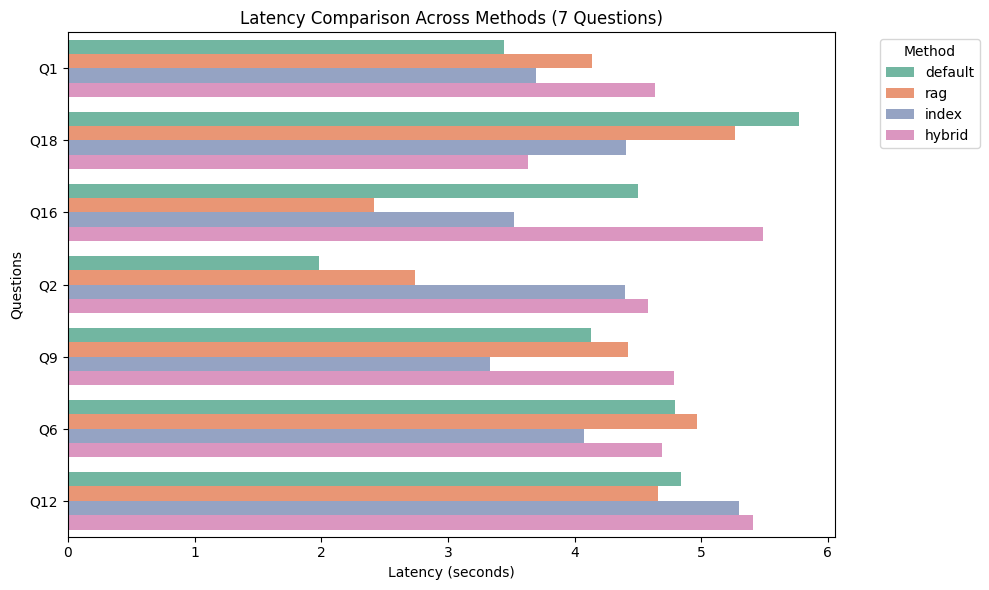

In [7]:
methods = ['default', 'rag', 'index', 'hybrid']

# Create short question labels
df['Q_num'] = ['Q'+str(i+1) for i in range(df.shape[0])]

# Pick any 7 questions (random sample)
df_sample = df.sample(7, random_state=42).reset_index(drop=True)

# Melt latency columns for the 7 questions
latency_cols = [f'{m}_latency' for m in methods]
latency_data = df_sample[['Q_num'] + latency_cols].melt(id_vars='Q_num', 
                                                        value_vars=latency_cols,
                                                        var_name='Method', 
                                                        value_name='Latency')
latency_data['Method'] = latency_data['Method'].str.replace('_latency','')

# Horizontal bar plot
plt.figure(figsize=(10,6))
sns.barplot(data=latency_data, x='Latency', y='Q_num', hue='Method', palette='Set2')
plt.title("Latency Comparison Across Methods (7 Questions)")
plt.xlabel("Latency (seconds)")
plt.ylabel("Questions")
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("latency_horizontal_7q.png")
plt.show()

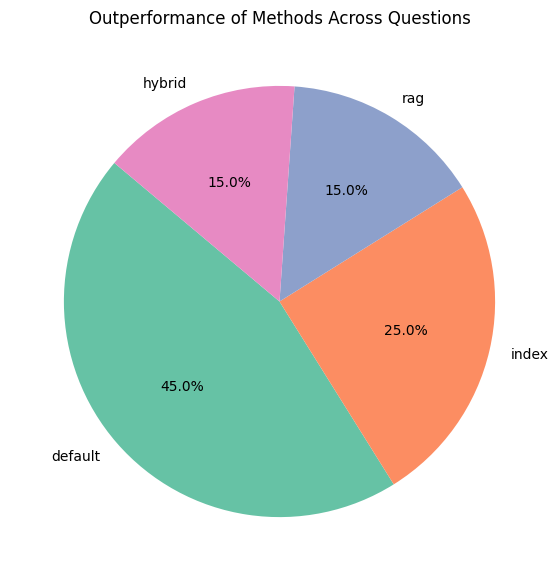

In [8]:
# Create a 'best method' column
df['best_method'] = df[[f'{m}_judge_final' for m in methods]].idxmax(axis=1)
df['best_method'] = df['best_method'].str.replace('_judge_final','')

# Count how many times each method outperformed others
outperf_counts = df['best_method'].value_counts()

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(outperf_counts, labels=outperf_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title("Outperformance of Methods Across Questions")
plt.savefig("method_outperformance_pie.png")
plt.show()

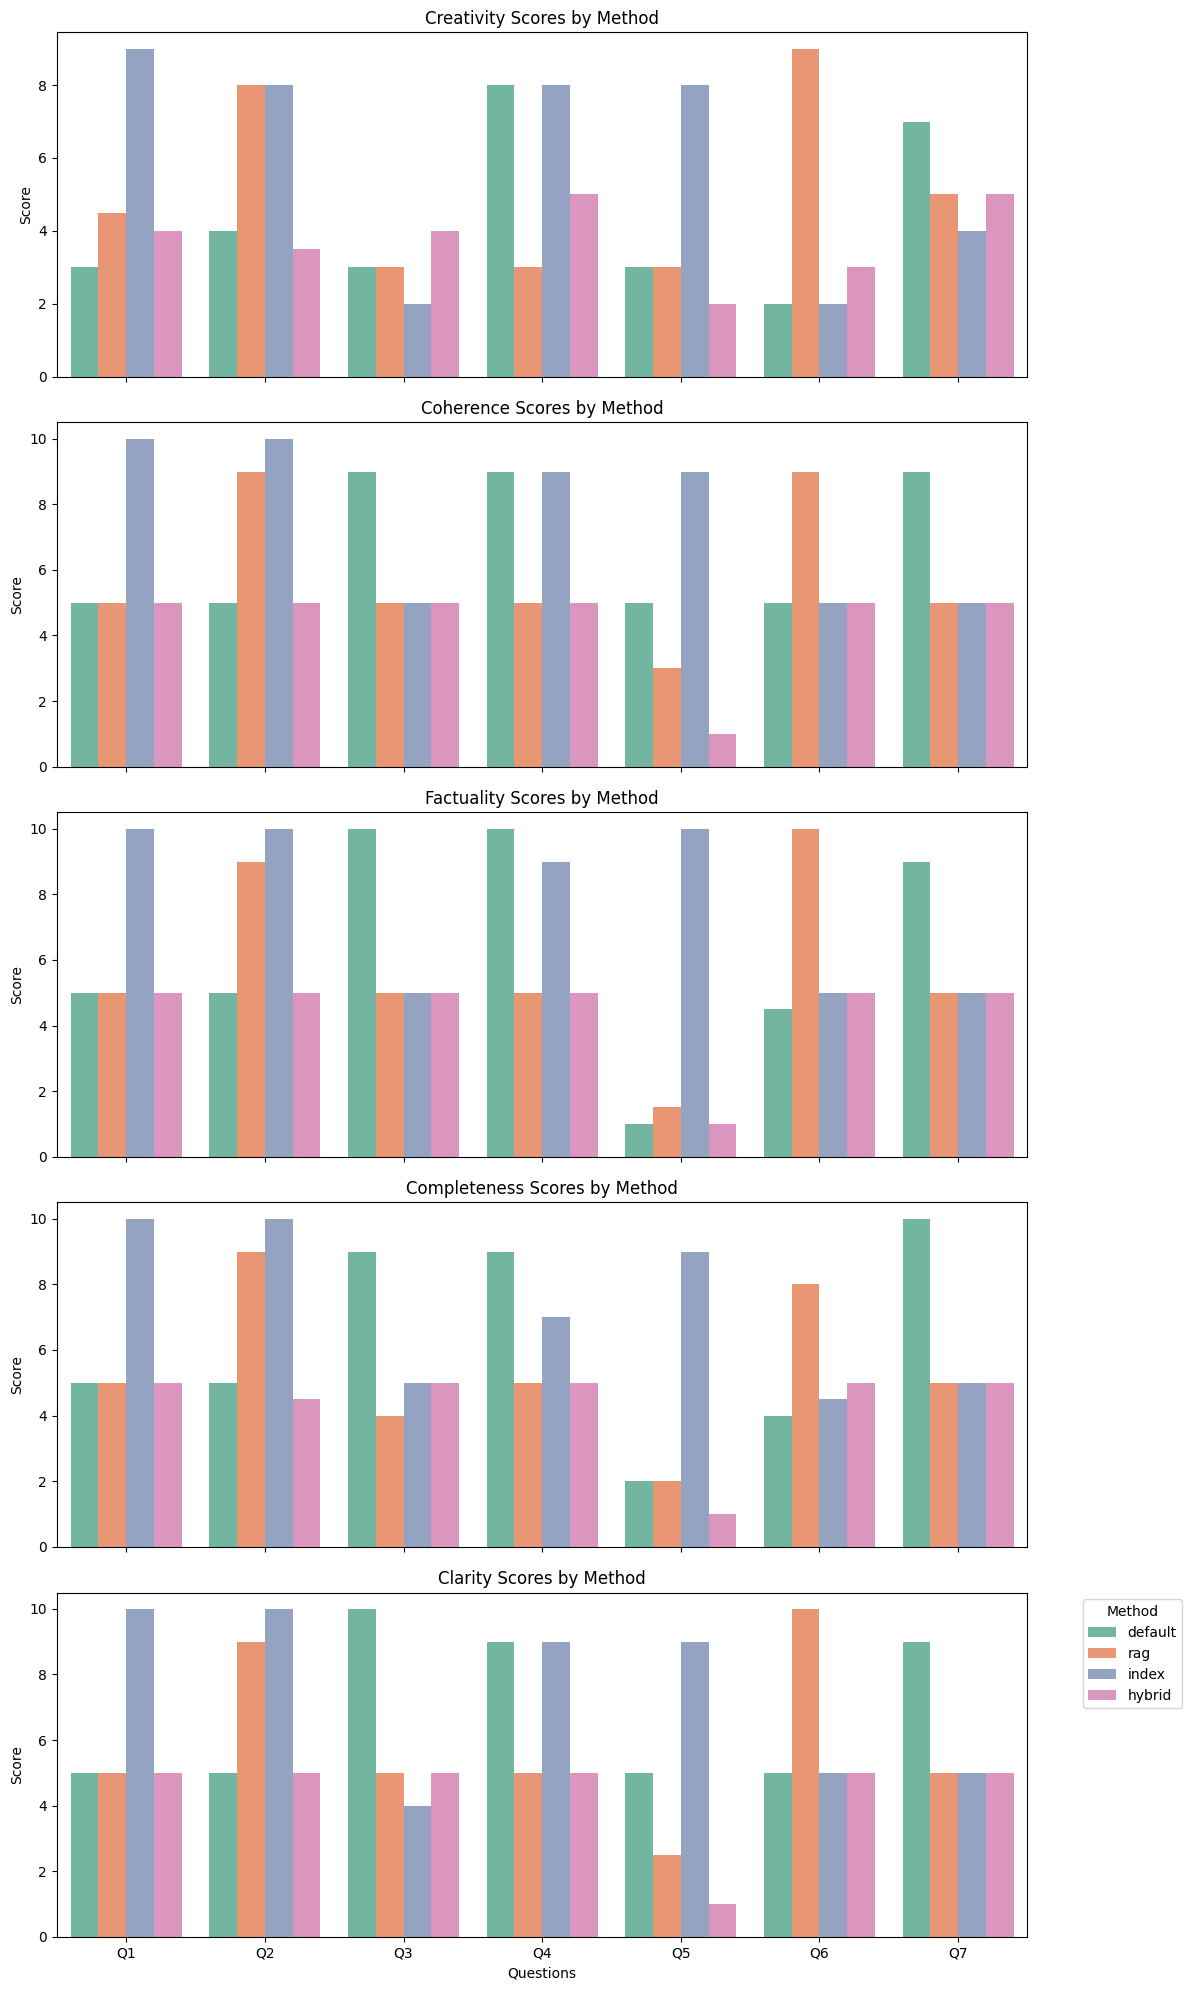

In [9]:
methods = ['default', 'rag', 'index', 'hybrid']
judge_metrics = ['creativity', 'coherence', 'factuality', 'completeness', 'clarity']

# Compute max judge_final per question
df['max_final'] = df[[f'{m}_judge_final' for m in methods]].max(axis=1)

# Pick top 7 questions by max judge_final
top_questions = df.nlargest(7, 'max_final').reset_index(drop=True)

# Create short question labels
top_questions['Q_num'] = ['Q'+str(i+1) for i in range(top_questions.shape[0])]

# Prepare data for plotting
plot_data = []
for _, row in top_questions.iterrows():
    q_label = row['Q_num']
    for method in methods:
        for metric in judge_metrics:
            plot_data.append({
                'Question': q_label,
                'Method': method,
                'Metric': metric,
                'Score': row[f'{method}_judge_{metric}']
            })
plot_df = pd.DataFrame(plot_data)

# Create vertical stacked plots
fig, axes = plt.subplots(len(judge_metrics), 1, figsize=(12, 20), sharex=True)

for i, metric in enumerate(judge_metrics):
    sns.barplot(
        data=plot_df[plot_df['Metric']==metric],
        x='Question', y='Score', hue='Method',
        palette='Set2', ax=axes[i]
    )
    axes[i].set_title(f"{metric.capitalize()} Scores by Method")
    axes[i].set_ylabel("Score")
    axes[i].set_xlabel("")  # Remove x-label for all except bottom
    if i < len(judge_metrics)-1:
        axes[i].legend_.remove()  # Keep legend only on last plot

# Legend for bottom plot
axes[-1].legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[-1].set_xlabel("Questions")

plt.tight_layout()
plt.savefig("vertical_judge_metrics.png")
plt.show()

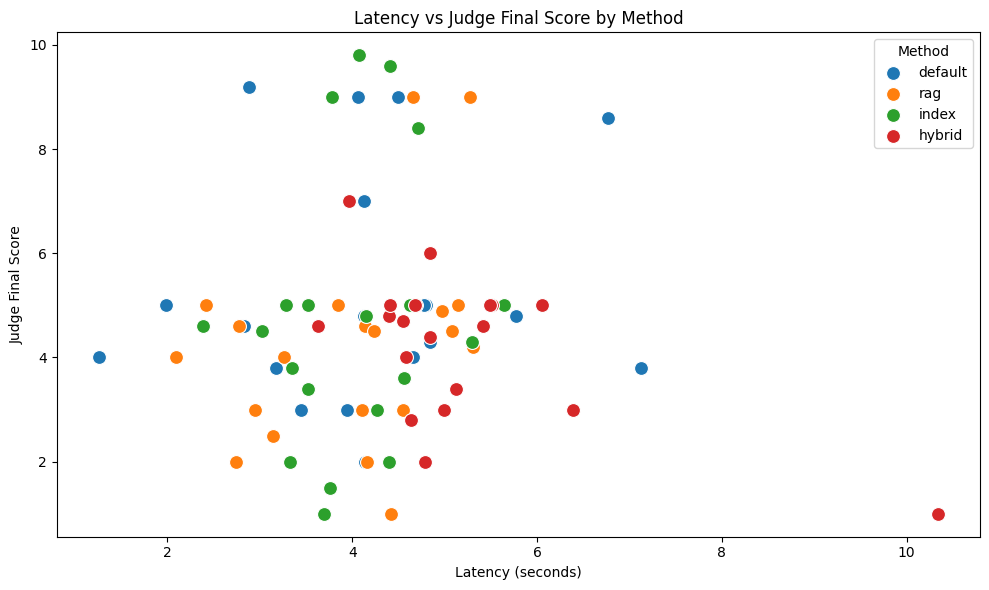

In [10]:
methods = ['default', 'rag', 'index', 'hybrid']

plt.figure(figsize=(10,6))
for method in methods:
    sns.scatterplot(
        data=df, 
        x=f'{method}_latency', 
        y=f'{method}_judge_final', 
        label=method, 
        s=100
    )

plt.title("Latency vs Judge Final Score by Method")
plt.xlabel("Latency (seconds)")
plt.ylabel("Judge Final Score")
plt.legend(title='Method')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


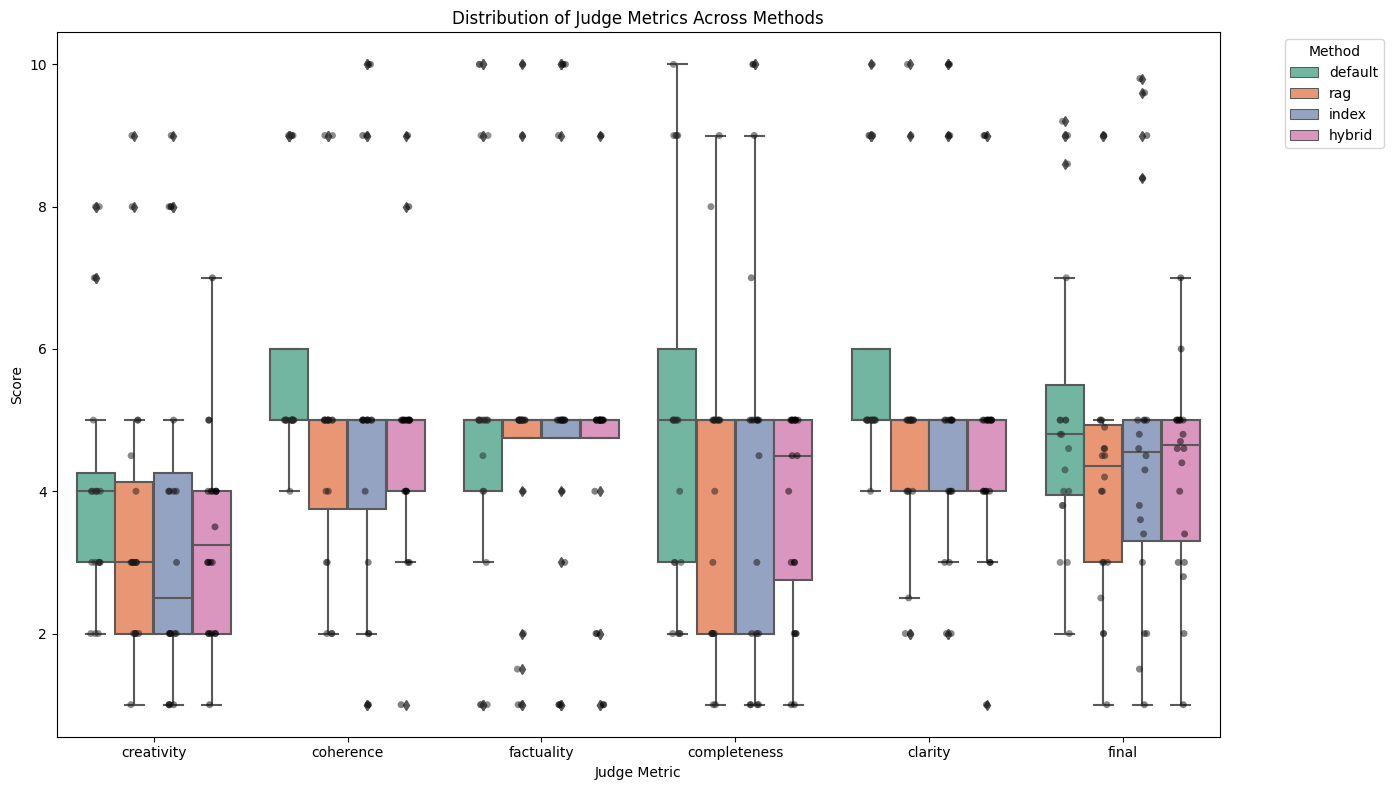

In [11]:
methods = ['default', 'rag', 'index', 'hybrid']
judge_metrics = ['creativity', 'coherence', 'factuality', 'completeness', 'clarity', 'final']

# Melt judge metrics for box plotting
box_data = []
for method in methods:
    for metric in judge_metrics:
        for idx, row in df.iterrows():
            box_data.append({
                'Method': method,
                'Metric': metric,
                'Score': row[f'{method}_judge_{metric}']
            })
box_df = pd.DataFrame(box_data)

# Plot boxplots for judge metrics
plt.figure(figsize=(14,8))
sns.boxplot(x='Metric', y='Score', hue='Method', data=box_df, palette='Set2')
sns.stripplot(x='Metric', y='Score', hue='Method', data=box_df,
              dodge=True, color='black', alpha=0.5, jitter=True)
plt.title("Distribution of Judge Metrics Across Methods")
plt.ylabel("Score")
plt.xlabel("Judge Metric")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(methods)], labels[:len(methods)], title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("boxplot_judge_metrics.png")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


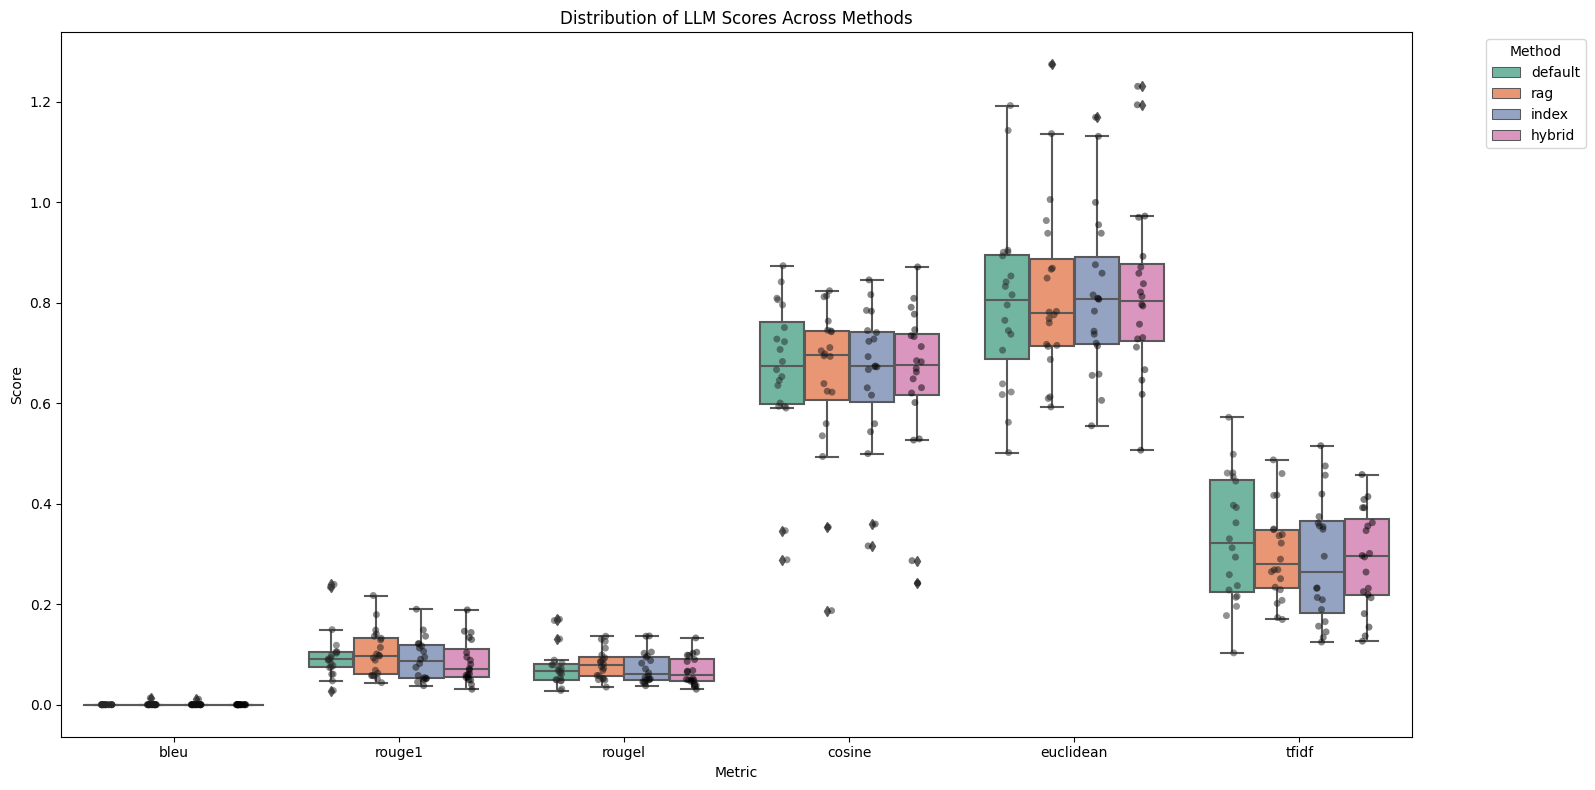

In [12]:
methods = ['default', 'rag', 'index', 'hybrid']
score_metrics = ['bleu', 'rouge1', 'rougel', 'cosine', 'euclidean', 'tfidf']  # add more if needed like BERTScore

# Melt scores for box plotting
box_data = []
for method in methods:
    for metric in score_metrics:
        col_name = f'{method}_{metric}'
        if col_name in df.columns:
            for idx, row in df.iterrows():
                box_data.append({
                    'Method': method,
                    'Metric': metric,
                    'Score': row[col_name]
                })
box_df = pd.DataFrame(box_data)

# Plot boxplots for all metrics
plt.figure(figsize=(16,8))
sns.boxplot(x='Metric', y='Score', hue='Method', data=box_df, palette='Set2')
sns.stripplot(x='Metric', y='Score', hue='Method', data=box_df,
              dodge=True, color='black', alpha=0.5, jitter=True)
plt.title("Distribution of LLM Scores Across Methods")
plt.ylabel("Score")
plt.xlabel("Metric")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:len(methods)], labels[:len(methods)], title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("boxplot_llm_scores.png")
plt.show()

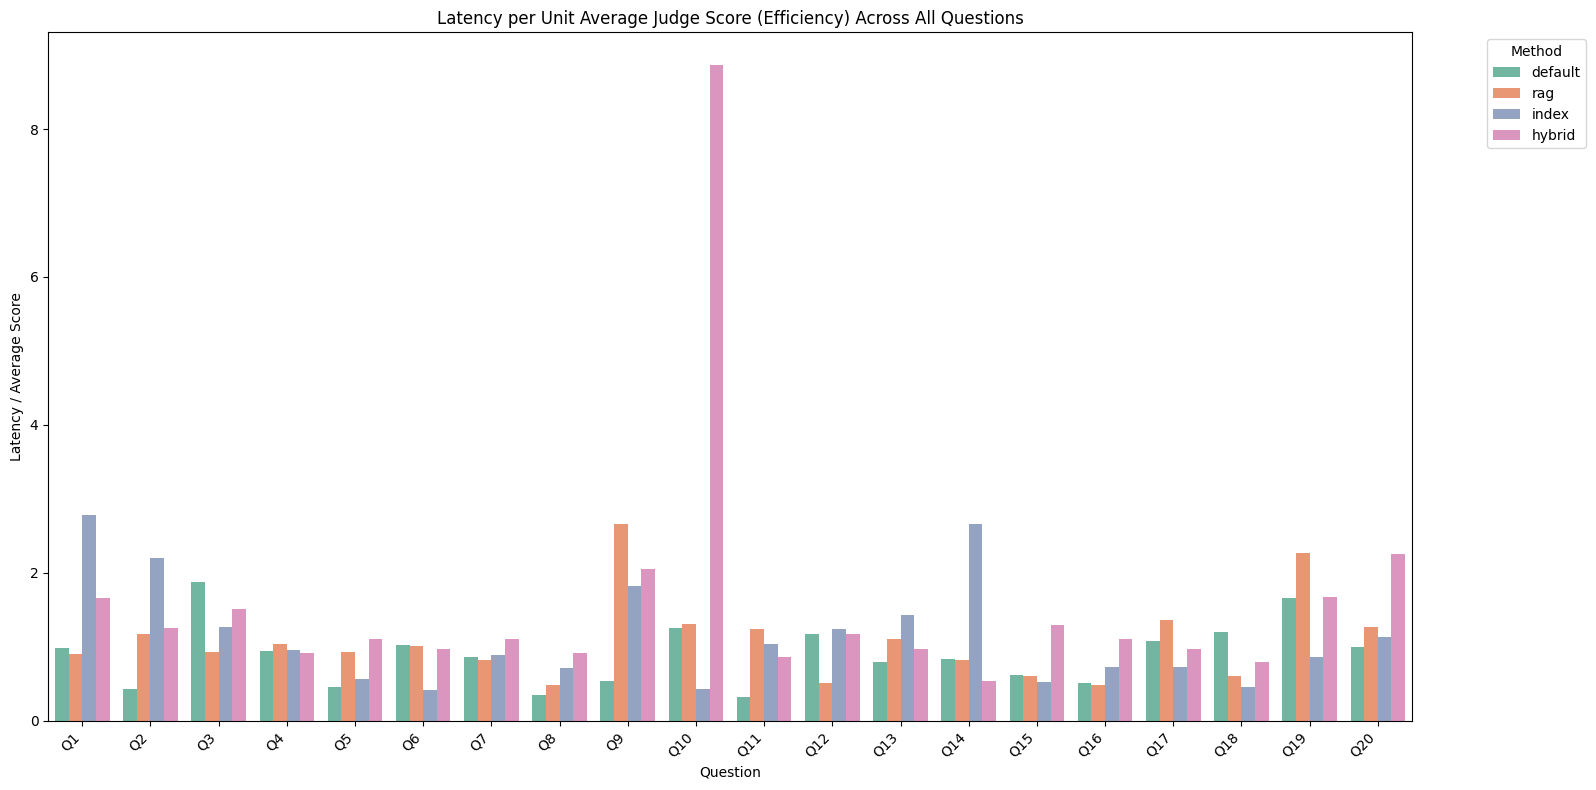

In [13]:
methods = ['default', 'rag', 'index', 'hybrid']
judge_metrics = ['creativity', 'coherence', 'factuality', 'completeness', 'clarity', 'final']

# Compute average judge score per method per question
for method in methods:
    df[f'{method}_avg_score'] = df[[f'{method}_judge_{m}' for m in judge_metrics]].mean(axis=1)
    df[f'{method}_latency_per_score'] = df[f'{method}_latency'] / df[f'{method}_avg_score']

# Melt for plotting
latency_score_cols = [f'{m}_latency_per_score' for m in methods]
latency_score_df = df[latency_score_cols].rename(columns=lambda x: x.replace('_latency_per_score',''))
latency_score_df['Q_num'] = ['Q'+str(i+1) for i in range(df.shape[0])]
latency_score_melt = latency_score_df.melt(id_vars='Q_num', var_name='Method', value_name='Latency_per_Score')

# Plot for all questions
plt.figure(figsize=(16,8))
sns.barplot(data=latency_score_melt, x='Q_num', y='Latency_per_Score', hue='Method', palette='Set2')
plt.title("Latency per Unit Average Judge Score (Efficiency) Across All Questions")
plt.xlabel("Question")
plt.ylabel("Latency / Average Score")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("latency_per_score_all.png")
plt.show()

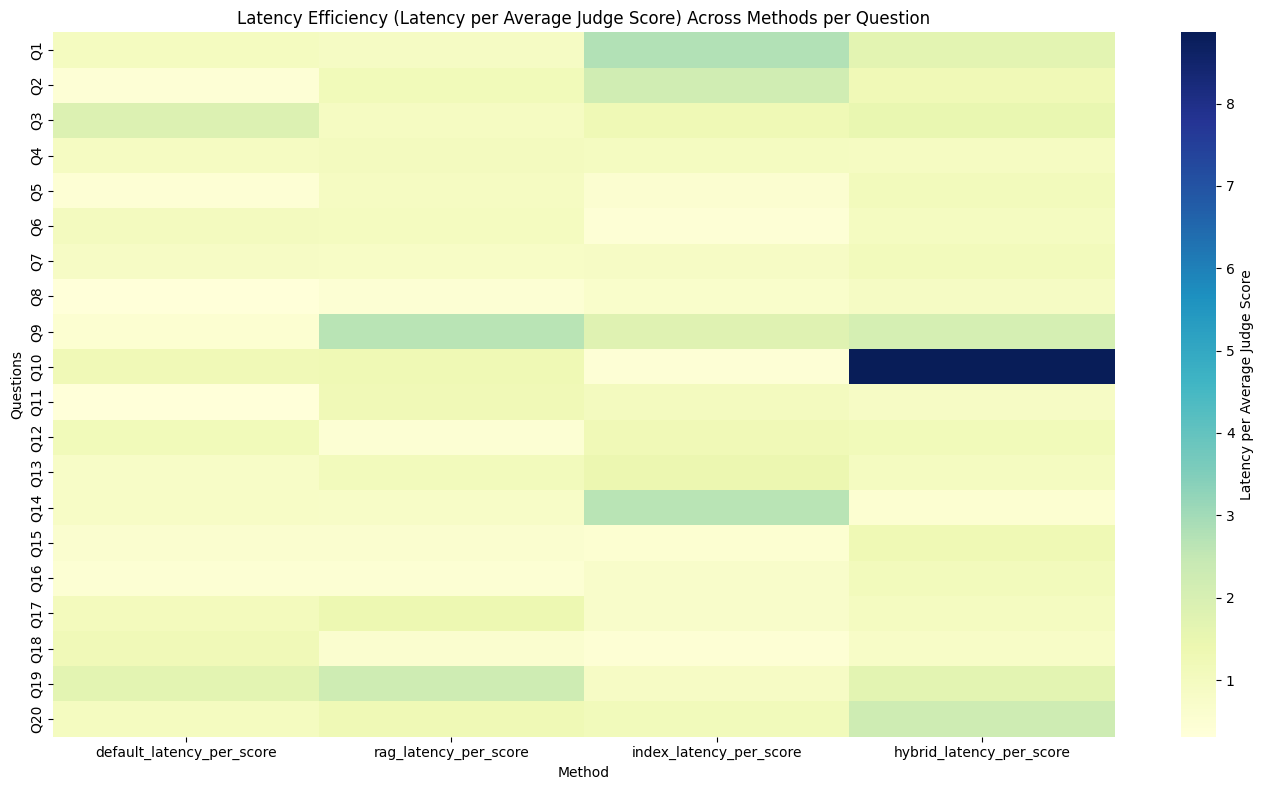

In [14]:
methods = ['default', 'rag', 'index', 'hybrid']
judge_metrics = ['creativity', 'coherence', 'factuality', 'completeness', 'clarity', 'final']

# Prepare a dataframe: Questions as rows, Methods*Judge_metrics as columns, plus latency
heat_data = pd.DataFrame()
heat_data['Q_num'] = ['Q'+str(i+1) for i in range(df.shape[0])]

for method in methods:
    for metric in judge_metrics:
        heat_data[f'{method}_{metric}'] = df[f'{method}_judge_{metric}']
    heat_data[f'{method}_latency'] = df[f'{method}_latency']

# Melt for seaborn heatmap
heat_melt = heat_data.melt(id_vars='Q_num', var_name='Metric', value_name='Score')

# Separate method and metric for plotting clarity
heat_melt['Method'] = heat_melt['Metric'].apply(lambda x: x.split('_')[0])
heat_melt['Metric_Name'] = heat_melt['Metric'].apply(lambda x: '_'.join(x.split('_')[1:]))

# Pivot to have Questions vs Metrics (Score = latency or judge)
# Let's compute latency per unit score for better meaning
heat_data_latency_eff = pd.DataFrame()
heat_data_latency_eff['Q_num'] = heat_data['Q_num']

for method in methods:
    avg_scores = df[[f'{method}_judge_{m}' for m in judge_metrics]].mean(axis=1)
    heat_data_latency_eff[f'{method}_latency_per_score'] = df[f'{method}_latency'] / avg_scores

# Heatmap: Questions vs Methods, value = latency per average judge score
plt.figure(figsize=(14,8))
sns.heatmap(heat_data_latency_eff.set_index('Q_num'), fmt=".2f", cmap='YlGnBu', cbar_kws={'label':'Latency per Average Judge Score'})
plt.title("Latency Efficiency (Latency per Average Judge Score) Across Methods per Question")
plt.xlabel("Method")
plt.ylabel("Questions")
plt.tight_layout()
plt.savefig("heatmap_latency_vs_judge.png")
plt.show()